In [1]:
import math
import graphviz
import math
import copy
import sys
import arff
import pprint

pp = pprint.PrettyPrinter(depth = 6)

In [2]:
class AICMetric(object):
    def compute_aic_metric(self, Bs, D):
        return EntropyMetric(Bs, D).compute_entropy_metric() + self.compute_k_factor(Bs)
    
    def compute_k_factor(self, network):
        k_factor = 0
        for node in network:
            k_factor += (len(node['r']) - 1) * self.count_number_of_parent_states(node)
        return k_factor
    
    def count_number_of_parent_states(self, node):
        counter = 0
        for parent in node['parents']:
            counter += len(parent['q'])
        return counter

In [3]:
class MDLMetric(object):
    def compute_mdl_metric(self, network, test_data):
        return EntropyMetric(network, test_data).compute_entropy_metric() + (self.compute_k_factor(network) / 2) * math.log10(len(test_data))
    
    def compute_k_factor(self, network):
        k_factor = 0
        for node in network:
             k_factor += (len(node['r']) - 1) * self.count_number_of_parent_states(node)
        return k_factor
    
    def count_number_of_parent_states(self, node):
        counter = 0
        for parent in node['parents']:
            counter += len(parent['q'])
        return counter

In [4]:
class EntropyMetric(object):
    """Entropy metric H(Bs, D) module (Bs - Bayes net, D - test data set)"""
    def __init__(self, network, test_data):
        self.network = network
        self.test_data = test_data
    
    def compute_entropy_metric(self):
        result = 0
        
        for node in self.network:
            if not node['parents']: # Brak rodzica
                result += self.compute_metric_for_node_without_parent(node)
                continue
                
            for node_state in node['r']:
                for parent in node['parents']:
                    for parent_state in parent['q']:
                        N_i_j = self.compute_occurences_for_all_node_states(node, (parent['name'], parent_state))
                        N_i_j_k = self.count_occurences((node['name'], node_state), (parent['name'], parent_state))
                        if (N_i_j_k != 0 and N_i_j != 0):
                            result += self.compute_metric_component(N_i_j, N_i_j_k)
                    
        return -1 * len(self.test_data) * result
    
    def compute_metric_for_node_without_parent(self, node):  
        N_i_j = len(self.test_data)
        N_i_j_k = self.compute_occurences_for_all_node_states_without_parent(node)
        
        return self.compute_metric_component(N_i_j, N_i_j_k)
    
    def compute_occurences_for_all_node_states(self, node, parent):
        result = 0
        for state in node['r']:
            result += self.count_occurences((node['name'], state), parent)
        return result
    
    def compute_occurences_for_all_node_states_without_parent(self, node):
        result = 0
        for state in node['r']:
            result += self.count_single_occurences(node['name'], state)
        return result
    
    def count_occurences(self, node, parent):
        counter = 0
        for data in self.test_data:
            if data[node[0]] == node[1] and data[parent[0]] == parent[1]:
                counter += 1 
        return counter
    
    def count_single_occurences(self, name, state):
        counter = 0
        for data in self.test_data:
            if data[name] == state:
                counter += 1 
        return counter
     
    def compute_metric_component(self, N_i_j, N_i_j_k):
        return (N_i_j_k / len(self.test_data)) * math.log10(N_i_j_k / N_i_j)

In [5]:
with open('data/weather.arff') as fh:
    data = arff.load(fh)
    
    attributes = []
    for i, p in enumerate(data['attributes']):
        attributes.append({'name': p[0], 'states': p[1]})
    
    sample_data = []
    for i, p in enumerate(data['data']):
        temp_dict = {}
        for j, d in enumerate(p):
            temp_dict.update({attributes[j]['name']: d})
        sample_data.append(temp_dict)
    
    index_of_class_attribute = 4
    print("Class argument: ")
    pp.pprint(attributes[index_of_class_attribute])
    
    final_attributes = []
    final_attributes.append(attributes[index_of_class_attribute])
    
    for i, p in enumerate(attributes):
        if i != index_of_class_attribute:
            final_attributes.append(p)

Class argument: 
{'name': 'play', 'states': ['yes', 'no']}


In [6]:
class K2Algorithm(object):
    def __init__(self, attributes, test_data, scoring_method, max_number_of_parents):
        self.test_data = test_data
        self.scoring_method = scoring_method
        self.attributes = attributes
        self.max_number_of_parents = max_number_of_parents
        
    def new_find_optimal_net(self):
        optimal_net = []
        
        for i, attribute in enumerate(self.attributes):
            parents_of_node_indexes = []
            find_more = True
        
            old_score = self.compute_metric([{'r': attribute['states'], 'name': attribute['name'], 'parents': []}])

            while (find_more and len(parents_of_node_indexes) < self.max_number_of_parents):
                max_new_parent_score, max_new_parent_index = self.find_node_with_max_score(i, attribute, parents_of_node_indexes)
                
                if (max_new_parent_score > old_score):
                    old_score = max_new_parent_score
                    parents_of_node_indexes.append(max_new_parent_index)
                else:
                    find_more = False
                    
            optimal_net.append({'r': attribute['states'], 'name': attribute['name'], 'parents': self.convert_array_of_indexes_to_parents(parents_of_node_indexes)})
                          
        return optimal_net
    
    def find_node_with_max_score(self, index, attribute, parent_indexes):
        current_parents = []
        for current_parent_index in parent_indexes:
            current_parents.append(self.convert_index_to_parent(current_parent_index))
        temp_net = [{'name': attribute['name'], 'r': attribute['states'], 'parents': current_parents}]
        
        parent_index_with_max_score = -1
        max_score = self.compute_metric(temp_net)
        
        for parent_index in range(0, index):
            if parent_index not in parent_indexes:
                temp_net_copy = copy.deepcopy(temp_net)
                temp_net_copy[0]['parents'].append(self.convert_index_to_parent(parent_index))
                parent_candidate_score = self.compute_metric(temp_net_copy)
                
                if (parent_candidate_score > max_score):
                    max_score = parent_candidate_score
                    parent_index_with_max_score = parent_index
                
        return (max_score, parent_index_with_max_score)
    
    def convert_index_to_parent(self, index):
        return {'name': self.attributes[index]['name'], 'q': self.attributes[index]['states']}
    
    def convert_array_of_indexes_to_parents(self, indexes):
        parents = []
        for index in indexes:
            parents.append(self.convert_index_to_parent(index))
        return parents
    
    def compute_metric(self, net):
        if self.scoring_method == 'aic':
            return AICMetric().compute_aic_metric(net, self.test_data)
        elif self.scoring_method == 'mdl':
            return MDLMetric().compute_mdl_metric(net, self.test_data)
        elif self.scoring_method == 'bayes':
            return BayesianMetric().compute_bayesian_metric(net, self.test_data)
        
        raise ValueError(self.scoring_method + " is not a valid scoring method!")

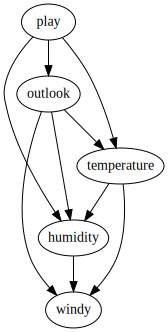

In [7]:
# Metody oceny sieci: 'aic', 'mdl' lub 'bayes'
bayesian_network = K2Algorithm(final_attributes, sample_data, 'aic', 3).new_find_optimal_net()

graph = graphviz.Digraph('generated graph')        
for node in bayesian_network:
    if not node['parents']:
        graph.node(node['name'] , label = node['name'])
    else:
        for parent in node['parents']:
            graph.edge(parent['name'], node['name'])          
graph